## Partie 4 : Intégration Numérique
Dans cette section, nous utilisons des méthodes d'intégration numérique pour analyser divers indicateurs épidémiologiques.

In [ ]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt


# Importation des modules internes du projet
from src.analysis import estimer_parametres_rab
from src.analysis.equations_differentielles.simulateur_sird import SimulateurSIRD
from src.analysis.integration.methodes import Integration
from src.data import DataPipeline

In [6]:
# Chargement des données pour le pays France
pipeline = DataPipeline(country="France")
df = pipeline.run(smoothing=True)

population = pipeline.population
parametres = estimer_parametres_rab(df)

### Question a) Estimation du nombre total d'infections
**Objectif** : Calculer le nombre total de personnes infectées entre $t_0$ et $t_f$ via l'intégrale :
$I_{total} = \int_{t_0}^{t_f} \frac{dI}{dt} dt = \int_{t_0}^{t_f} [rS(t)I(t) - (a + b)I(t)] dt$</br>
**Méthode** : Utilisation de la méthode de Simpson sur le terme $rS(t)I(t)P$ (où $P$ = population totale).

In [7]:
# Calcul du flux d'infections
df["flux_infections"] = parametres["r"] * df["S"] * df["I"] * population

# Intégration numérique
I_total = Integration(df=df, col="flux_infections", h=1.0).simpson()

#### Résultats

In [8]:
print(f"Nombre total d'infections estimé : {I_total:.2f} personnes")

Nombre total d'infections estimé : 37059513.77 personnes


### Question b) Cas cumulés et guérisons
**Objectif** : Calculer les quantités cumulées via :</br>
$I_{cum}(t) = \int_0^t rS(\tau)I(\tau)d\tau,\quad R_{cum}(t) = \int_0^t aI(\tau)d\tau$</br>
*À implémenter : Adaptation du code de la Question a avec des intégrales cumulatives.*

### Question c) Durée totale de l'épidémie
**Objectif** : Déterminer le temps $T$ où $I(T) \approx 0$ via : </br>
$\int_{t_0}^T \frac{dI}{dt}dt \approx 0$ </br>
*À implémenter : Algorithme de recherche de racine sur $I(t)$.*

### Question d) Impact des mesures de contrôle
**Objectif** : Quantifier la réduction d'infections grâce aux mesures sanitaires via :</br>
$\text{Impact} = \int_0^T I_{\text{sans}}(t)dt - \int_0^T I_{\text{avec}}(t)dt$

In [9]:
# Définition de la date de confinement (2e confinement en France)
# Le confinement a officiellement commencé le 30 octobre 2020.
# Toutefois, l'effet sur la dynamique épidémique est différé de plusieurs jours.
# Pour éviter de capturer des dynamiques pré-confinement, on décale la période de prise en compte à +10 jours.
date_confinement = "2020-11-09"

# Segmenter les données en deux périodes
df_sans_mesures = df[df["date"] < date_confinement].copy()
df_avec_mesures = df[df["date"] >= date_confinement].copy()

# Estimer les paramètres pour chaque période
params_sans = estimer_parametres_rab(df_sans_mesures)
params_avec = estimer_parametres_rab(df_avec_mesures)

# Affichage des paramètres pour interprétation
print("Paramètres sans mesures:", params_sans)
print("Paramètres avec mesures:", params_avec)

Paramètres sans mesures: {'r': 0.09215113198601729, 'a': 0.05045253688668397, 'b': 0.0019648018142611116}
Paramètres avec mesures: {'r': 0.0965779400366315, 'a': 0.07320780039953993, 'b': 0.0003167130858381202}


In [10]:
# Simulation numérique de la propagation de l'épidémie à l'aide du modèle SIRD
# pour chaque ensemble de paramètres (sans et avec mesures)

# Simulation
t_max = 365
simulateur_sans = SimulateurSIRD(params_sans)
result_sans = simulateur_sans.resoudre(
    df=df_sans_mesures, t_max=t_max, dt=1.0, methode="rk4"
)

simulateur_avec = SimulateurSIRD(params_avec)
result_avec = simulateur_avec.resoudre(
    df=df_avec_mesures, t_max=t_max, dt=1.0, methode="rk4"
)


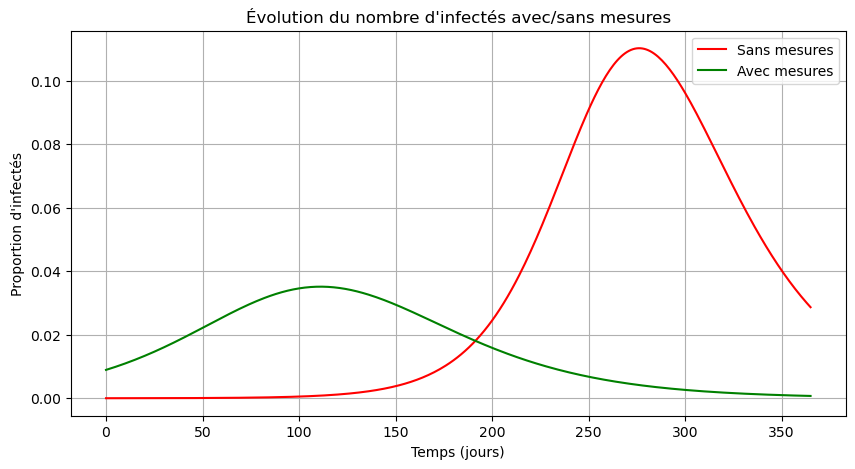

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(result_sans["temps"], result_sans["I"], label="Sans mesures", color="red")
plt.plot(result_avec["temps"], result_avec["I"], label="Avec mesures", color="green")
plt.xlabel("Temps (jours)")
plt.ylabel("Proportion d'infectés")
plt.title("Évolution du nombre d'infectés avec/sans mesures")
plt.legend()
plt.grid(True)
plt.show()

#### Résultats

In [11]:
# Calcul de l'intégrale de la courbe des infectés pour chaque simulation
# Cela permet d'estimer le "nombre de personnes × jours" infectées

# Intégration sur la période sans mesures
intg_sans = Integration(df=result_sans, col="I", h=1.0)
integral_sans = intg_sans.simpson() * pipeline.population

# Intégration sur la période avec mesures
intg_avec = Integration(df=result_avec, col="I", h=1.0)
integral_avec = intg_avec.simpson() * pipeline.population

# Impact des mesures
impact = integral_sans - integral_avec
print(f"Réduction des cas grâce aux mesures : {impact:.2f} (personnes × jours)")

Réduction des cas grâce aux mesures : 448377625.10 (personnes × jours)


### Question e) Stratégie vaccinale
**Objectif** : Calculer le nombre de doses nécessaires pour l'immunité collective via : </br>
$N_{vacc} = \int_0^T V(t)dt \quad \text{où } V(t) = \text{taux de vaccination}$ </br>
*À implémenter : Intégration des données de vaccination.*